# Example 06 - Wideband Modulations Signal Detector
This notebook walks through the process of using TorchSig to instantiate the WBSig53 dataset, load a pretrained DETR model, train the DETR model for signal detection, and evaluate its performance through plots and mean average precision (mAP) scores.

----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit.

In [1]:
from torchsig.datasets.wideband_sig53 import WidebandSig53
from torchmetrics.detection import MeanAveragePrecision
from torch.utils.data import DataLoader
from torchsig.transforms.target_transforms import DescToBBoxSignalDict, ListTupleToDesc
from torchsig.transforms.transforms import Spectrogram, Normalize, Compose, Identity
from torchsig.models.spectrogram_models.detr.modules import SetCriterion
from torchsig.models.spectrogram_models.detr.detr import detr_b0_nano, format_preds, format_targets
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import torch
import time
import os

----
### Instantiate WBSig53 Dataset
Here, we instantiate the WBSig53 dataset for training and validation. Please see example notebook 03 for more details on WBSig53. If you plan to compare your results with the baseline performance metrics, please use the impaired datasets by setting `impaired = True`.

In [2]:
# Specify WidebandSig53 Options
root = '/media/gvanhoy/external/test/wideband_sig53/'
fft_size = 512

transform = Compose([
    Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='complex'),
    Normalize(norm=np.inf, flatten=True),
])

target_transform = Compose([
    DescToBBoxSignalDict()
])

# Instantiate the training WidebandSig53 Dataset
wideband_sig53_train = WidebandSig53(
    root=root, 
    train=True, 
    impaired=True,
    transform=transform,
    target_transform=target_transform,
)

# Instantiate the validation WidebandSig53 Dataset
wideband_sig53_val = WidebandSig53(
    root=root, 
    train=False, 
    impaired=True,
    transform=transform,
    target_transform=target_transform,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_sig53_val))
data, label = wideband_sig53_val[idx]
print("Training Dataset length: {}".format(len(wideband_sig53_train)))
print("Validation Dataset length: {}".format(len(wideband_sig53_val)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label))

Training Dataset length: 250
Validation Dataset length: 25
Data shape: (2, 512, 512)
Label: {'labels': tensor([0]), 'boxes': tensor([[0.5000, 0.5000, 0.5000, 0.5000]])}


----
### Format Dataset for Training
Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataloaders
train_dataloader = DataLoader(
    dataset=wideband_sig53_train,
    batch_size=4,
    num_workers=8,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
)

val_dataloader = DataLoader(
    dataset=wideband_sig53_val,
    batch_size=4,
    num_workers=8,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
)

----
### Instantiate Supported TorchSig Model
Below, we load a pretrained DETR-B0-Nano model, and then conform it to a PyTorch LightningModule for training.

In [4]:
model = detr_b0_nano(
    pretrained=True,
    path="detr_b0_nano.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
class ExampleDETR(pl.LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleDETR, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader
        self.loss_fn = SetCriterion()
        
        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size
        
    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        return self.data_loader
    
    def training_step(self, batch, _):
        x, y = batch
        x = torch.stack([torch.as_tensor(xi, device=self.device) for xi in x], dim=0)
        y_hat = self.forward(x.float())
        loss_vals = self.loss_fn(y_hat, y)
        loss = self.loss_fn.weight_dict["loss_ce"] * loss_vals["loss_ce"] + \
            self.loss_fn.weight_dict["loss_bbox"] * loss_vals["loss_bbox"] + \
            self.loss_fn.weight_dict["loss_giou"] * loss_vals["loss_giou"]
        return {'loss':loss}
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def validation_step(self, batch, _):
        x, y = batch
        x = torch.stack([torch.as_tensor(xi, device=self.device) for xi in x], dim=0)
        y_hat = self.forward(x.float())
        loss_vals = self.loss_fn(y_hat, y)
        loss = self.loss_fn.weight_dict["loss_ce"] * loss_vals["loss_ce"] + \
            self.loss_fn.weight_dict["loss_bbox"] * loss_vals["loss_bbox"] + \
            self.loss_fn.weight_dict["loss_giou"] * loss_vals["loss_giou"]
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True, batch_size=4)
        return {'val_loss': loss}
        
example_model = ExampleDETR(model, train_dataloader, val_dataloader)

----
### Train the Model
To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.

In [6]:
# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 50
trainer = pl.Trainer(
    max_epochs=epochs,
    callbacks=checkpoint_callback,
    accelerator="gpu",
    devices=[0],
    accumulate_grad_batches=4,
)
trainer.fit(example_model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/gvanhoy/.virtual_envs/python38/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | mdl     | DETRModel    | 8.2 M 
1 | loss_fn | SetCriterion | 0     
-----------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.721    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 62/62 [00:10<00:00,  6.12it/s, v_num=13, val_loss=2.440]

Epoch 0, global step 16: 'val_loss' reached 2.43729 (best 2.43729), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 1: 100%|██████████| 62/62 [00:10<00:00,  5.95it/s, v_num=13, val_loss=1.330]

Epoch 1, global step 32: 'val_loss' reached 1.32601 (best 1.32601), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 2: 100%|██████████| 62/62 [00:10<00:00,  6.17it/s, v_num=13, val_loss=1.340]

Epoch 2, global step 48: 'val_loss' was not in top True


Epoch 3: 100%|██████████| 62/62 [00:10<00:00,  5.95it/s, v_num=13, val_loss=1.190]

Epoch 3, global step 64: 'val_loss' reached 1.18594 (best 1.18594), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 4: 100%|██████████| 62/62 [00:09<00:00,  6.34it/s, v_num=13, val_loss=2.890]

Epoch 4, global step 80: 'val_loss' was not in top True


Epoch 5: 100%|██████████| 62/62 [00:10<00:00,  5.78it/s, v_num=13, val_loss=1.180]

Epoch 5, global step 96: 'val_loss' reached 1.17805 (best 1.17805), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 6: 100%|██████████| 62/62 [00:10<00:00,  5.94it/s, v_num=13, val_loss=1.220]

Epoch 6, global step 112: 'val_loss' was not in top True


Epoch 7: 100%|██████████| 62/62 [00:11<00:00,  5.57it/s, v_num=13, val_loss=1.670]

Epoch 7, global step 128: 'val_loss' was not in top True


Epoch 8: 100%|██████████| 62/62 [00:10<00:00,  5.73it/s, v_num=13, val_loss=1.120]

Epoch 8, global step 144: 'val_loss' reached 1.12065 (best 1.12065), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 9: 100%|██████████| 62/62 [00:10<00:00,  5.95it/s, v_num=13, val_loss=1.110]

Epoch 9, global step 160: 'val_loss' reached 1.11232 (best 1.11232), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 10: 100%|██████████| 62/62 [00:10<00:00,  5.85it/s, v_num=13, val_loss=0.904]

Epoch 10, global step 176: 'val_loss' reached 0.90384 (best 0.90384), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 11: 100%|██████████| 62/62 [00:11<00:00,  5.53it/s, v_num=13, val_loss=0.924]

Epoch 11, global step 192: 'val_loss' was not in top True


Epoch 12: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s, v_num=13, val_loss=1.010]

Epoch 12, global step 208: 'val_loss' was not in top True


Epoch 13: 100%|██████████| 62/62 [00:11<00:00,  5.59it/s, v_num=13, val_loss=0.991]

Epoch 13, global step 224: 'val_loss' was not in top True


Epoch 14: 100%|██████████| 62/62 [00:10<00:00,  5.88it/s, v_num=13, val_loss=0.974]

Epoch 14, global step 240: 'val_loss' was not in top True


Epoch 15: 100%|██████████| 62/62 [00:10<00:00,  5.94it/s, v_num=13, val_loss=1.150]

Epoch 15, global step 256: 'val_loss' was not in top True


Epoch 16: 100%|██████████| 62/62 [00:10<00:00,  6.05it/s, v_num=13, val_loss=0.889]

Epoch 16, global step 272: 'val_loss' reached 0.88855 (best 0.88855), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 17: 100%|██████████| 62/62 [00:10<00:00,  6.15it/s, v_num=13, val_loss=1.090]

Epoch 17, global step 288: 'val_loss' was not in top True


Epoch 18: 100%|██████████| 62/62 [00:10<00:00,  5.87it/s, v_num=13, val_loss=0.977]

Epoch 18, global step 304: 'val_loss' was not in top True


Epoch 19: 100%|██████████| 62/62 [00:10<00:00,  5.70it/s, v_num=13, val_loss=0.858]

Epoch 19, global step 320: 'val_loss' reached 0.85834 (best 0.85834), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 20: 100%|██████████| 62/62 [00:11<00:00,  5.62it/s, v_num=13, val_loss=0.808]

Epoch 20, global step 336: 'val_loss' reached 0.80768 (best 0.80768), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 21: 100%|██████████| 62/62 [00:11<00:00,  5.55it/s, v_num=13, val_loss=0.960]

Epoch 21, global step 352: 'val_loss' was not in top True


Epoch 22: 100%|██████████| 62/62 [00:10<00:00,  5.87it/s, v_num=13, val_loss=1.260]

Epoch 22, global step 368: 'val_loss' was not in top True


Epoch 23: 100%|██████████| 62/62 [00:10<00:00,  5.74it/s, v_num=13, val_loss=0.889]

Epoch 23, global step 384: 'val_loss' was not in top True


Epoch 24: 100%|██████████| 62/62 [00:10<00:00,  5.96it/s, v_num=13, val_loss=0.799]

Epoch 24, global step 400: 'val_loss' reached 0.79853 (best 0.79853), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 25: 100%|██████████| 62/62 [00:10<00:00,  5.67it/s, v_num=13, val_loss=0.784]

Epoch 25, global step 416: 'val_loss' reached 0.78429 (best 0.78429), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 26: 100%|██████████| 62/62 [00:10<00:00,  5.97it/s, v_num=13, val_loss=0.844]

Epoch 26, global step 432: 'val_loss' was not in top True


Epoch 27: 100%|██████████| 62/62 [00:11<00:00,  5.53it/s, v_num=13, val_loss=0.803]

Epoch 27, global step 448: 'val_loss' was not in top True


Epoch 28: 100%|██████████| 62/62 [00:10<00:00,  5.76it/s, v_num=13, val_loss=0.782]

Epoch 28, global step 464: 'val_loss' reached 0.78223 (best 0.78223), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 29: 100%|██████████| 62/62 [00:10<00:00,  6.13it/s, v_num=13, val_loss=0.899]

Epoch 29, global step 480: 'val_loss' was not in top True


Epoch 30: 100%|██████████| 62/62 [00:10<00:00,  5.71it/s, v_num=13, val_loss=0.781]

Epoch 30, global step 496: 'val_loss' reached 0.78124 (best 0.78124), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 31: 100%|██████████| 62/62 [00:10<00:00,  5.91it/s, v_num=13, val_loss=0.705]

Epoch 31, global step 512: 'val_loss' reached 0.70524 (best 0.70524), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 32: 100%|██████████| 62/62 [00:10<00:00,  5.89it/s, v_num=13, val_loss=0.846]

Epoch 32, global step 528: 'val_loss' was not in top True


Epoch 33: 100%|██████████| 62/62 [00:10<00:00,  5.76it/s, v_num=13, val_loss=0.752]

Epoch 33, global step 544: 'val_loss' was not in top True


Epoch 34: 100%|██████████| 62/62 [00:10<00:00,  5.78it/s, v_num=13, val_loss=0.777]

Epoch 34, global step 560: 'val_loss' was not in top True


Epoch 35: 100%|██████████| 62/62 [00:11<00:00,  5.54it/s, v_num=13, val_loss=0.768]

Epoch 35, global step 576: 'val_loss' was not in top True


Epoch 36: 100%|██████████| 62/62 [00:10<00:00,  5.81it/s, v_num=13, val_loss=0.800]

Epoch 36, global step 592: 'val_loss' was not in top True


Epoch 37: 100%|██████████| 62/62 [00:10<00:00,  6.09it/s, v_num=13, val_loss=0.901]

Epoch 37, global step 608: 'val_loss' was not in top True


Epoch 38: 100%|██████████| 62/62 [00:10<00:00,  5.69it/s, v_num=13, val_loss=1.240]

Epoch 38, global step 624: 'val_loss' was not in top True


Epoch 39: 100%|██████████| 62/62 [00:10<00:00,  5.65it/s, v_num=13, val_loss=0.949]

Epoch 39, global step 640: 'val_loss' was not in top True


Epoch 40: 100%|██████████| 62/62 [00:11<00:00,  5.28it/s, v_num=13, val_loss=0.680]

Epoch 40, global step 656: 'val_loss' reached 0.67983 (best 0.67983), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 41: 100%|██████████| 62/62 [00:10<00:00,  6.06it/s, v_num=13, val_loss=0.802]

Epoch 41, global step 672: 'val_loss' was not in top True


Epoch 42: 100%|██████████| 62/62 [00:10<00:00,  5.79it/s, v_num=13, val_loss=0.726]

Epoch 42, global step 688: 'val_loss' was not in top True


Epoch 43: 100%|██████████| 62/62 [00:10<00:00,  5.86it/s, v_num=13, val_loss=0.778]

Epoch 43, global step 704: 'val_loss' was not in top True


Epoch 44: 100%|██████████| 62/62 [00:10<00:00,  5.64it/s, v_num=13, val_loss=0.771]

Epoch 44, global step 720: 'val_loss' was not in top True


Epoch 45: 100%|██████████| 62/62 [00:10<00:00,  6.16it/s, v_num=13, val_loss=0.709]

Epoch 45, global step 736: 'val_loss' was not in top True


Epoch 46: 100%|██████████| 62/62 [00:10<00:00,  5.86it/s, v_num=13, val_loss=0.857]

Epoch 46, global step 752: 'val_loss' was not in top True


Epoch 47: 100%|██████████| 62/62 [00:10<00:00,  5.68it/s, v_num=13, val_loss=0.697]

Epoch 47, global step 768: 'val_loss' was not in top True


Epoch 48: 100%|██████████| 62/62 [00:10<00:00,  6.12it/s, v_num=13, val_loss=0.653]

Epoch 48, global step 784: 'val_loss' reached 0.65296 (best 0.65296), saving model to '/home/gvanhoy/Documents/torchsig/examples/checkpoints/checkpoint-v3.ckpt' as top True


Epoch 49: 100%|██████████| 62/62 [00:10<00:00,  5.89it/s, v_num=13, val_loss=0.709]

Epoch 49, global step 800: 'val_loss' was not in top True
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 62/62 [00:10<00:00,  5.88it/s, v_num=13, val_loss=0.709]


----
### Evaluate the Trained Model
Once the network is fully trained, we load the best checkpoint and then infer over a few random samples, inspecting the performance through plots.

In [7]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint['state_dict'])
example_model = example_model.eval()

In [9]:
preds = {}
data_collection = {}
label_collection = {}
results_collection = {}

threshold = 0.8
fft_size = 512

num_eval = 6
for p in range(num_eval):
    # Retrieve data
    idx = np.random.randint(len(wideband_sig53_val))
    data, label = wideband_sig53_val[idx]
    data_collection[p] = data
    
    # Infer
    with torch.no_grad():
        data = torch.from_numpy(np.expand_dims(data,0)).float()
        data = data.to(example_model.device)
        pred = example_model(data)
    preds[p] = pred
    
    # Convert output to detections dataframe
    component_num = 0
    column_names = ["DetectionIdx", "Probability", "CenterTimePixel", "DurationPixel", "CenterFreqPixel", "BandwidthPixel", "Class"]
    detected_signals_df = pd.DataFrame(columns = column_names)
    
    # Loop over the number of objects DETR outputs
    for obj_idx in range(pred['pred_logits'].shape[1]):
        probs = pred['pred_logits'][0][obj_idx].softmax(-1)
        max_prob = probs.max().cpu().detach().numpy()
        max_class = probs.argmax().cpu().detach().numpy()
        
        # If max class is not the last class for no object, interpret values
        if max_class != (pred['pred_logits'].shape[2] - 1) and max_prob > threshold:
            center_time = pred['pred_boxes'][0][obj_idx][0]
            center_freq = pred['pred_boxes'][0][obj_idx][1]
            duration = pred['pred_boxes'][0][obj_idx][2]
            bandwidth = pred['pred_boxes'][0][obj_idx][3]
        
            # Save to dataframe
            detected_signals_df.at[component_num,"DetectionIdx"] = component_num
            detected_signals_df.at[component_num,"Probability"] = max_prob
            detected_signals_df.at[component_num,"CenterTimePixel"] = center_time.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"DurationPixel"] = duration.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"CenterFreqPixel"] = center_freq.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"BandwidthPixel"] = bandwidth.cpu().detach().numpy() * fft_size
            detected_signals_df.at[component_num,"Class"] = max_class
            component_num += 1

    # Save to results collection
    results_collection[p] = detected_signals_df
    
    # Convert label to labels dataframe
    component_num = 0
    labels_df = pd.DataFrame(columns = column_names)
    
    for label_obj_idx in range(len(label['labels'])):
        center_time = label["boxes"][label_obj_idx][0]
        center_freq = label["boxes"][label_obj_idx][1]
        duration = label["boxes"][label_obj_idx][2]
        bandwidth = label["boxes"][label_obj_idx][3]
        class_name = label["labels"][label_obj_idx]

        # Save to dataframe
        labels_df.at[component_num,"DetectionIdx"] = component_num
        labels_df.at[component_num,"Probability"] = 1.0
        labels_df.at[component_num,"CenterTimePixel"] = center_time * fft_size
        labels_df.at[component_num,"DurationPixel"] = duration * fft_size
        labels_df.at[component_num,"CenterFreqPixel"] = center_freq * fft_size
        labels_df.at[component_num,"BandwidthPixel"] = bandwidth * fft_size
        labels_df.at[component_num,"Class"] = class_name
        component_num += 1

    # Save to label collection
    label_collection[p] = labels_df

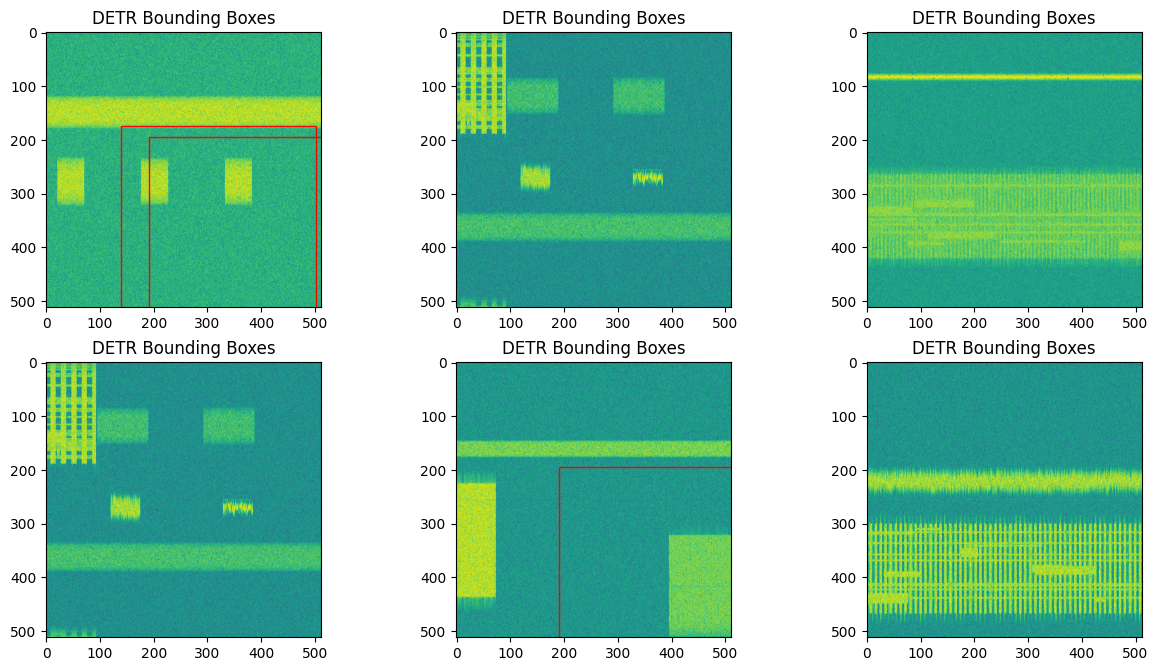

In [10]:
include_annotation = False

plt.figure(figsize=(15, 25))
for i in range(num_eval):
    ax = plt.subplot(num_eval,3,i+1)
    
    # Convert complex spectrogram to magnitude for plotting
    data_plot = np.squeeze(data_collection[i])
    data_plot = data_plot[0]**2 + data_plot[1]**2
    data_plot = 20*np.log10(data_plot)

    # Retrieve individual label
    ax.imshow(data_plot)
    for sig_idx in range(results_collection[i].shape[0]):
        rect = mpl.patches.Rectangle(
            (results_collection[i].iloc[sig_idx]["CenterTimePixel"]-results_collection[i].iloc[sig_idx]["DurationPixel"]/2,
             results_collection[i].iloc[sig_idx]["CenterFreqPixel"]-results_collection[i].iloc[sig_idx]["BandwidthPixel"]/2),
            results_collection[i].iloc[sig_idx]["DurationPixel"],
            results_collection[i].iloc[sig_idx]["BandwidthPixel"],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        if include_annotation:
            ax.annotate(
                "{:.1f}%".format(results_collection[i].iloc[sig_idx]["Probability"]*100), 
                (
                    results_collection[i].iloc[sig_idx]["CenterTimePixel"]+results_collection[i].iloc[sig_idx]["DurationPixel"]/2, 
                    results_collection[i].iloc[sig_idx]["CenterFreqPixel"]-results_collection[i].iloc[sig_idx]["BandwidthPixel"]/2
                ), 
                color='w', 
                weight='bold', 
                fontsize=8, 
                ha='right', 
                va='bottom',
             )
        
    plt.title("DETR Bounding Boxes")
plt.show()

----
### Compute the Mean Average Precision
As a final evaluation technique, we use the TorchMetrics's `MeanAveragePrecision` metric for computing the mAP. Please note that the TorchMetrics mAP computation is fairly slow, but it is the recommended tool for comparing to the performance baselines we provide.

In [11]:
mAP_metric = MeanAveragePrecision(class_metrics=False)

fft_size = 512
batch_size = 32
num_eval = len(wideband_sig53_val)
data_idx = 0

fp16 = True

model = model.eval().cuda()
if fp16:
    # Note: only the backbone supports fp16 precision at this time
    model.backbone = model.backbone.half()
    model.conv = model.conv.half()
    model.transformer = model.transformer.float()
    model.linear_class = model.linear_class.float()
    model.linear_bbox = model.linear_bbox.float()
else:
    model.backbone = model.backbone.float()
    model.conv = model.conv.float()
    model.transformer = model.transformer.float()
    model.linear_class = model.linear_class.float()
    model.linear_bbox = model.linear_bbox.float()

for curr_batch in tqdm(range(num_eval // batch_size)):
    # Create batch
    batch = np.zeros((batch_size, 2, fft_size, fft_size))
    label_batch = []
    for batch_element in range(batch_size):
        # Retrieve data
        idx = data_idx if num_eval == len(wideband_sig53_val) else np.random.randint(len(wideband_sig53_val))
        data_idx += 1
        data, label = wideband_sig53_val[idx]
        batch[batch_element,:] = data
        label_batch.append(label)
    
    # Infer
    with torch.no_grad():
        model_input = torch.from_numpy(batch)
        model_input = model_input.cuda() if torch.cuda.is_available() else model_input
        if fp16:
            x = model.backbone(model_input.half())
            h = model.conv(x)
            h = model.transformer(h.float()).float()
            preds = {
                'pred_logits': model.linear_class(h), 
                'pred_boxes': model.linear_bbox(h).sigmoid()
            }
        else:
            preds = model(model_input.float())
        
    # Format the predictions to match the torchmetrics input format
    map_preds = format_preds(preds)
    map_targets = format_targets(label_batch)
    mAP_score = mAP_metric.update(map_preds, map_targets)
    
# Calc mAP
print("Computing metrics...")
start_time = time.time()
mAP_dict = mAP_metric.compute()
mAP_score = float(mAP_dict['map'].numpy())
print("Done computing metrics in {:.2f}s".format(time.time() - start_time))

print("mAP: {}".format(mAP_score))
mAP_dict

0it [00:00, ?it/s]

Computing metrics...
Done computing metrics in 0.00s
mAP: -1.0



/home/gvanhoy/.virtual_envs/python38/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


{'map': tensor(-1.),
 'map_50': tensor(-1.),
 'map_75': tensor(-1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(-1.),
 'mar_10': tensor(-1.),
 'mar_100': tensor(-1.),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}